In [3]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import ROOT
import focal
import optuna
#import logging
#import plotly
#from plotly.io import show
import sys
import torch

# Notebook to map events to the format of the adjacency matrix

And maybe implement parts of Modified Aggregation

In [2]:
adj = np.load("p2_adj.npy")
idx = np.load("p2_cell_idx.npy")

Think about modified aggregation

Have adjacency matrix, have cell indices

From new event in ttree, sort values to match adjacency

Maybe a bespoke heatmap plot for the prototype 2 adjacency matrix for easy test, otherwise just fill in the labels

Use search(). Loop over ttree coordinates and map indices, EZPZ. Maybe precompute events and store in zipped numpy array.

Try looping and mapping over 1000 events, see how slow it is.

In [34]:
file = ROOT.TFile("/home/bjartur/workspace/focalh_data_transformer/data/converted/E300_P5_N1000.root", "READ")
tree = file.Get("EventsTree")


Create some structure that maps an array of mapped indices to the filename and tree event, so you are always sure.

In [34]:
def p2_adj_map(filename):
    """
    Function to basically check and record the mapping for a file.
    I think all simulation files will always be the same, but this
    checks that all events have the same mapping and returns the mapping
    and file name.
    """
    file = ROOT.TFile(filename, "READ")
    tree = file.Get("EventsTree")
    Nevents = tree.GetEntries()
    tree.GetEntry(0)
    npval = np.array(tree.value, dtype=np.float32)

    f = focal.FocalH()
    Ncells = len(npval)
    iadj = np.zeros(Ncells*Nevents, dtype=np.int32).reshape(Nevents,Ncells)
    inv = np.zeros(Ncells*Nevents, dtype=np.int32).reshape(Nevents,Ncells)
    for k in range(Nevents):
        tree.GetEntry(k)
        npx = np.array(tree.x, dtype=np.float32)
        npy = np.array(tree.y, dtype=np.float32)
        npval = np.array(tree.value, dtype=np.float32)
        for i in range(len(npval)):
            trans = f.search(npx[i],npy[i])
            iadj[k,i] = trans # wrong order?
        
        #print(npval[0])

    if (iadj == iadj[0]).all():
        return iadj[0], filename

    print("All events don't have the same order of cells!")
    return np.ones(Ncells)*-1, filename

iadj = p2_adj_map("/home/bjartur/workspace/python_focalh_clustering/data/E150_P3_N1000.root")

In [35]:
print(f"Want to map {174} to {244}. But iadj[174] is {iadj[0][174]}")
print(f"Hmm")
print(f"For some reason my mapping turns into iadj[4] which is {iadj[0][4]}")

Want to map 174 to 244. But iadj[174] is 244
Hmm
For some reason my mapping turns into iadj[4] which is 174


In [27]:
t = np.array([0,1,2,3,4,5])
m = np.array([4,1,3,2,5,0])
inv = np.argsort(m)
print("t:")
print(t)

print()
print("Transforms:")
print(t[m])
print(t[m][m])
print(t[m][m][m])

print()
print(t[m][inv])


t:
[0 1 2 3 4 5]

Transforms:
[4 1 3 2 5 0]
[5 1 2 3 0 4]
[0 1 3 2 4 5]

[0 1 2 3 4 5]


In [36]:
np.save("p2_sim_adj_map", iadj[0])
inv = np.argsort(iadj[0])
np.save("p2_sim_adj_map2", inv)

In [37]:
iadj = np.load("p2_sim_adj_map.npy")
iadj2 = np.load("p2_sim_adj_map2.npy")

In [41]:
iadj2[174]

np.int64(4)

From a ttree I can now translate the indices to the p2 indices.

That means I can conceivably implement the modified aggregation in python.

I should make a toy example first and implement it there.

I should have a way of visualizing if the mapping and later clustering works.

First just make a toy example and implement the MA.

# Toy example

In [5]:
toy_cells = np.array([0,1,2,3,4,5,6,7,8])
toy_cells2 = np.array([0,1,2,3,4,5,6,7,8,9,10,11])


toy_ex = np.array([
[0,1,2],
[3,4,5],
[6,7,8]
])

toy_vals = np.array([
[5,1,1],
[1,1,1],
[1,1,1]
])

toy_vals2 = np.array([
[5,4,3],
[4,4,3],
[3,3,3],
[2,2,6]
])



toy_adj = np.array([
#0  1  2  3  4  5  6  7  8
[1, 1, 0, 1, 1, 0, 0, 0, 0],
[1, 1, 1, 1, 1, 1, 0, 0, 0],
[0, 1, 1, 0, 1, 1, 0, 0, 0],
[1, 1, 0, 1, 1, 0, 1, 1, 0],
[1, 1, 1, 1, 1, 1, 1, 1, 1],
[0, 1, 1, 0, 1, 1, 0, 1, 1],
[0, 0, 0, 1, 1, 0, 1, 1, 0],
[0, 0, 0, 1, 1, 1, 1, 1, 1],
[0, 0, 0, 0, 1, 1, 0, 1, 1],
])

toy_adj2 = np.array([
#0  1  2  3  4  5  6  7  8  9  10 11
[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
[0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0],
[1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
[0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0],
[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1],

[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0],
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1],
])


toy_adj

array([[1, 1, 0, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 0, 1, 1, 0, 0, 0],
       [1, 1, 0, 1, 1, 0, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 0, 1, 1, 0, 1, 1],
       [0, 0, 0, 1, 1, 0, 1, 1, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 0, 1, 1]])

In [6]:
(toy_adj2 == toy_adj2.T).all()

np.True_

In [7]:
toy_vals.flatten()

array([5, 1, 1, 1, 1, 1, 1, 1, 1])

In [5]:
def ModifiedAggregation(A, v, seed=4, agg=0):
    """
    Modified Aggregation from an adjacency matrix and a list of values
    corresponding to the same ordering as the adjacency matrix.
    """

    if seed <= agg:
        print("Seed threshold can't be smaller than aggregation threshold")
        return
    
    labels = np.zeros_like(v, dtype=np.int32)
    count = 0
    tag_it = 1
    while(count < 1E6):
        seed_mask = v < seed
        limit_mask = labels != 0
        masked_data = ma.masked_array(v, mask = seed_mask | limit_mask)
        #print("Possible seeds", masked_data)
        
        if np.all(masked_data.mask):  # Check if all elements are masked
            break
        max_index = masked_data.argmax()
        seed_mask[max_index] = True
        spread(A,v,max_index,labels,tag_it,agg)
        tag_it += 1
        count += 1

    return labels

def spread(A,v,seed,labels,tag,agg):
    """
    Spread
    """
    spread_mask = A[seed] == 1
    spread_mask = np.zeros_like(labels).astype(bool)
    spread_mask[seed] = True
    
    # later make into while
    labels_temp = np.ones_like(labels)*-1
    count = 0
    while(count < 1E6):
        count += 1
        limit_mask = labels == 0

        if (labels_temp==labels).all():
            break        
        labels_temp = labels.copy()
        
        spread_to_idx = np.where(spread_mask)[0]
        for icell in spread_to_idx:
            propagate(A,v,icell,spread_mask,labels,tag,agg)


def propagate(A,v,cell,spread_mask,labels,tag,agg):
    """
    Spread to neighbors and check value and agg threshold.
    Check A for neighbors, make a mask for already tagged.
    """

#    print("Propagating...")
    limit_mask = labels == 0
    value_mask = v <= v[cell]
    agg_mask = v > agg
    mask = A[cell]
#    print(mask)
#    print(limit_mask)
#    print(value_mask)
#    print(agg_mask)
#    final_mask = np.bitwise_and(mask, limit_mask & value_mask & agg_mask).astype(bool)
    final_mask = np.bitwise_and(mask.astype(bool), limit_mask & value_mask & agg_mask).astype(bool)

    # Tag
    labels[final_mask] = tag

    # Update spreading cells
    # This might not be efficient.
    spread_mask[final_mask] = True



Text(0.5, 1.0, 'Clusters')

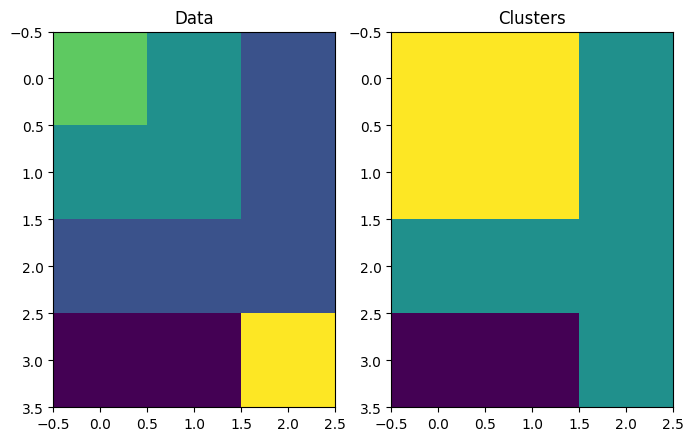

In [9]:
clusters = ModifiedAggregation(toy_adj2, toy_vals2.flatten(), seed=3, agg=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,6))
ax[0].imshow(toy_vals2)
ax[0].set_title("Data")
ax[1].imshow(clusters.reshape(4,3))
ax[1].set_title("Clusters")

# Test with real data

In [633]:
adj = np.load("p2_adj.npy")
idx = np.load("p2_cell_idx.npy")
iadj = np.load("p2_sim_adj_map.npy")
file = ROOT.TFile("/home/bjartur/workspace/focalh_data_transformer/data/converted/E150_P1_N1000.root", "READ")
tree = file.Get("EventsTree")

In [634]:
tree.GetEntry(250)
vals = np.array(tree.value, dtype=np.float32).clip(max=4096)
x = np.array(tree.x, dtype=np.float32)
y = np.array(tree.y, dtype=np.float32)

In [635]:
for i in range(1000):
    clusters = ModifiedAggregation(adj, vals[iadj], seed=800, agg=0)

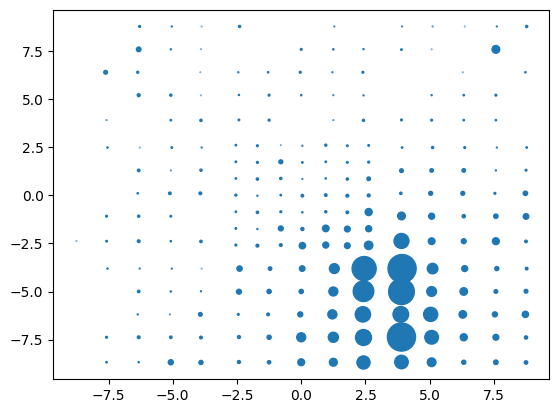

In [636]:
plt.scatter(x,y,s=vals/10)

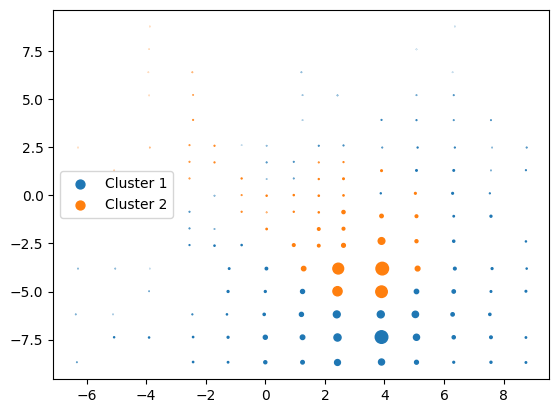

In [637]:
for c in set(clusters):
    if c == 0:
        continue
    cl = clusters == c
    plt.scatter(x[iadj][cl],y[iadj][cl],label="Cluster "+str(c), s=vals[iadj][cl]/50)

plt.legend()

# Bigger test

Maybe with Optuna

In [3]:
adj = np.load("p2_adj.npy")
idx = np.load("p2_cell_idx.npy")
iadj = np.load("p2_sim_adj_map.npy")
file = ROOT.TFile("/home/bjartur/workspace/focalh_data_transformer/data/converted/E60_P3_N1000.root", "READ")
tree = file.Get("EventsTree")
Nentries = tree.GetEntries()

In [65]:
tree.GetEntry(0)
npval = np.array(tree.value).clip(max=4096)
nppart = len(set(tree.labels))
npfrac = np.array(tree.fractions)
nplab = np.array(tree.labels, dtype=np.int32)

s = 0
for p in range(1,nppart+1):
    mask = nplab == p
    s += (npfrac[mask] * npval).sum()
    print(s)


print(npval.sum())

21372.00048816207
22115.00048816207
22532.0
22532.0


In [3]:
"""
FOCAL2_CELLS = 249
FOCAL2_SAT = 4096
npx = np.zeros(Nentries*FOCAL2, dtype=np.float32).reshape(Nentries, FOCAL2_CELLS)
npy = np.zeros(Nentries*FOCAL2, dtype=np.float32).reshape(Nentries, FOCAL2_CELLS)
npval = np.zeros(Nentries*FOCAL2, dtype=np.float32).reshape(Nentries, FOCAL2_CELLS)
nppart = np.zeros(Nentries, dtype=np.int32)
for i in range(Nentries):
    tree.GetEntry(i)
    npx[i] = np.array(tree.x)
    npy[i] = np.array(tree.y)
    npval[i] = np.array(tree.value).clip(max=FOCAL2_SAT)
    nppart[i] = len(set(tree.labels))


clusters = np.zeros(Nentries*FOCAL2, dtype=np.int32).reshape(Nentries, FOCAL2_CELLS)
clusternum = np.zeros(Nentries, dtype=np.int32)
for i in range(Nentries):
    clusters[i] = ModifiedAggregation(adj, npval[i][iadj], seed=800, agg=0)
    mask = clusters[i] != 0
    clusternum[i] = len(set(clusters[i][mask]))
"""

def data(filename):
    tfile = ROOT.TFile(filename, "READ")
    ttree = tfile.Get("EventsTree")
    Nentries = ttree.GetEntries()

    FOCAL2_CELLS = 249
    FOCAL2_SAT = 4096
    npx = np.zeros(Nentries*FOCAL2_CELLS, dtype=np.float32).reshape(Nentries, FOCAL2_CELLS)
    npy = np.zeros(Nentries*FOCAL2_CELLS, dtype=np.float32).reshape(Nentries, FOCAL2_CELLS)
    npval = np.zeros(Nentries*FOCAL2_CELLS, dtype=np.float32).reshape(Nentries, FOCAL2_CELLS)
    nppart = np.zeros(Nentries, dtype=np.int32)
    for i in range(Nentries):
        ttree.GetEntry(i)
        npx[i] = np.array(ttree.x)
        npy[i] = np.array(ttree.y)
        npval[i] = np.array(ttree.value).clip(max=FOCAL2_SAT)
        nppart[i] = len(set(ttree.labels))
    tfile.Close()
    return npx, npy, npval, nppart

def MA_clustering(seed,agg,x,y,val,particles):

    adj = np.load("p2_adj.npy")
    idx = np.load("p2_cell_idx.npy")
    iadj = np.load("p2_sim_adj_map.npy")

    Nentries = len(x)
    FOCAL2_CELLS = 249
    clusters = np.zeros(Nentries*FOCAL2_CELLS, dtype=np.int32).reshape(Nentries, FOCAL2_CELLS)
    clusternum = np.zeros(Nentries, dtype=np.int32)
    for i in range(Nentries):
        clusters[i] = ModifiedAggregation(adj, val[i][iadj], seed=seed, agg=agg)
        mask = clusters[i] != 0
        clusternum[i] = len(set(clusters[i][mask]))
    eff = clusternum / particles
    return eff, clusters

#eff = clusternum / nppart
#print(eff.mean(), eff.std())

In [75]:
_,_,_, lab, _ = data("/home/bjartur/workspace/focalh_data_transformer/data/converted/E60_P3_N1000.root")

In [70]:
lab

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [101]:
x,y,val,p = data("/home/bjartur/workspace/focalh_data_transformer/data/converted/E60_P3_N1000.root")
{'seed': 807.7425621277989, 'agg': 728.8106252968716}
eff,cl = MA_clustering(807.7425621277989,728.8106252968716,x,y,val,p)
print(eff.mean())

1.0643333333333334


In [95]:
print(eff.mean()-1)

-0.6183333333333334


In [89]:
cl[0]

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0], dtype=int32)

1.2985


In [58]:
# Set the logging level for Optuna to WARNING or higher to suppress informational messages
logging.getLogger('optuna').setLevel(logging.WARNING)

def optuna_ma(datafiles, Nevents=100, Ntrials=10):
    #print("Optimizing:", datafile)
    x = []
    y = []
    val = []
    p = []
    for f in datafiles:
        xt, yt, valt, pt = data(f)
        for i in range(len(xt)):        
            x.append(xt[i])
            y.append(yt[i])
            val.append(valt[i])
            p.append(pt[i])

    x = np.array(x)
    y = np.array(y)
    val = np.array(val)
    p = np.array(p)

#    x, y, val, p = data(datafiles[0])
    print("Data done")

    
    
    
    #x,y,val,p = data(datafiles[0])
    total_size = x.nbytes + y.nbytes + val.nbytes + p.nbytes
    print(x.shape, y.shape, val.shape, p.shape, "approx size:", total_size/1E6, "MB")
    x, y, val, p = shuffle(x, y, val, p)
    if len(x) > Nevents:
        x, y, val, p = x[0:Nevents], y[0:Nevents], val[0:Nevents], p[0:Nevents]
    total_size = x.nbytes + y.nbytes + val.nbytes + p.nbytes
    print(x.shape, y.shape, val.shape, p.shape, "approx size:", total_size/1E6, "MB")


    
    def cluster_objective(trial):
        seed = trial.suggest_float("seed", 0, 4096)
        agg = trial.suggest_float("agg", 0, 4096)

        if agg >= seed:
            return float("inf")

        eff,cl = MA_clustering(seed,agg,x,y,val,p)
        sq_eff_mu = (eff**2).mean()
        eff_mu = eff.mean()
        eff_sigma = eff.std()

        return (eff_mu - 1)**2
    
    study = optuna.create_study()
    study.optimize(cluster_objective, n_trials=Ntrials)
    print("Done.")
    return study

files = [

        "/home/bjartur/workspace/focalh_data_transformer/data/converted/E60_P1_N1000.root",
        "/home/bjartur/workspace/focalh_data_transformer/data/converted/E60_P2_N1000.root",
        "/home/bjartur/workspace/focalh_data_transformer/data/converted/E60_P3_N1000.root",
        "/home/bjartur/workspace/focalh_data_transformer/data/converted/E60_P5_N1000.root",
        "/home/bjartur/workspace/focalh_data_transformer/data/converted/E60_P10_N1000.root",
    
        "/home/bjartur/workspace/focalh_data_transformer/data/converted/E150_P1_N1000.root",
        "/home/bjartur/workspace/focalh_data_transformer/data/converted/E150_P2_N1000.root",
        "/home/bjartur/workspace/focalh_data_transformer/data/converted/E150_P3_N1000.root",
        "/home/bjartur/workspace/focalh_data_transformer/data/converted/E150_P5_N1000.root",
        "/home/bjartur/workspace/focalh_data_transformer/data/converted/E150_P10_N1000.root",

        "/home/bjartur/workspace/focalh_data_transformer/data/converted/E300_P1_N1000.root",
        "/home/bjartur/workspace/focalh_data_transformer/data/converted/E300_P2_N1000.root",
        "/home/bjartur/workspace/focalh_data_transformer/data/converted/E300_P3_N1000.root",
        "/home/bjartur/workspace/focalh_data_transformer/data/converted/E300_P5_N1000.root",
        "/home/bjartur/workspace/focalh_data_transformer/data/converted/E300_P10_N1000.root",
    
        ]

study = optuna_ma(files, 1000, 2)

Data done
(15000, 249) (15000, 249) (15000, 249) (15000,) approx size: 44.88 MB
(1000, 249) (1000, 249) (1000, 249) (1000,) approx size: 2.992 MB
Done.


{'seed': 1013.9269792470484, 'agg': 639.6527898666548}


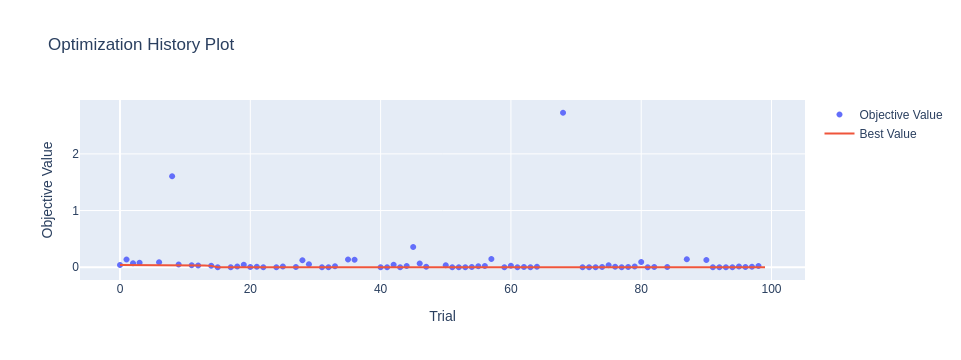

In [18]:
study = optuna_ma(files, 1000, 100)
fig = optuna.visualization.plot_optimization_history(study)
print(study.best_trial.params)
show(fig)

[W 2025-08-11 15:07:26,412] Trial 0 is omitted in visualization because its objective value is inf or nan.
[W 2025-08-11 15:07:26,414] Trial 4 is omitted in visualization because its objective value is inf or nan.
[W 2025-08-11 15:07:26,415] Trial 5 is omitted in visualization because its objective value is inf or nan.
[W 2025-08-11 15:07:26,416] Trial 7 is omitted in visualization because its objective value is inf or nan.
[W 2025-08-11 15:07:26,416] Trial 9 is omitted in visualization because its objective value is inf or nan.
[W 2025-08-11 15:07:26,417] Trial 15 is omitted in visualization because its objective value is inf or nan.
[W 2025-08-11 15:07:26,419] Trial 20 is omitted in visualization because its objective value is inf or nan.
[W 2025-08-11 15:07:26,420] Trial 24 is omitted in visualization because its objective value is inf or nan.
[W 2025-08-11 15:07:26,421] Trial 28 is omitted in visualization because its objective value is inf or nan.
[W 2025-08-11 15:07:26,421] Trial

{'seed': 1193.1647844913125, 'agg': 484.04942938174645}


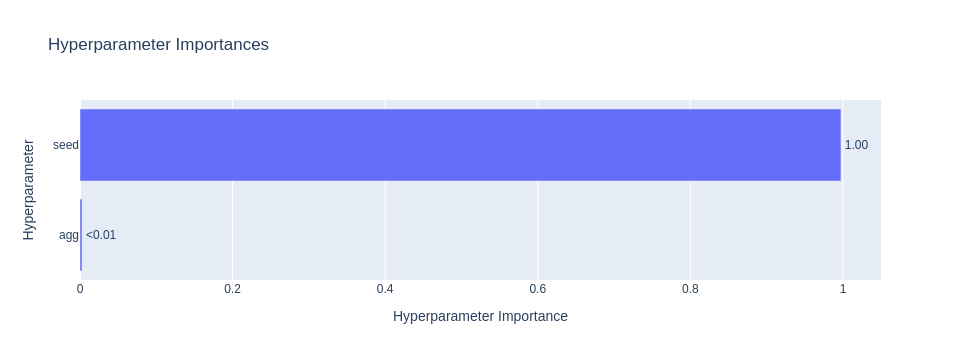

In [62]:
fig = optuna.visualization.plot_param_importances(study)
print(study.best_trial.params)
show(fig)


Data done
(15000, 249) (15000, 249) (15000, 249) (15000,) approx size: 44.88 MB
(100, 249) (100, 249) (100, 249) (100,) approx size: 0.2992 MB
Done.
{'seed': 1193.1647844913125, 'agg': 484.04942938174645}


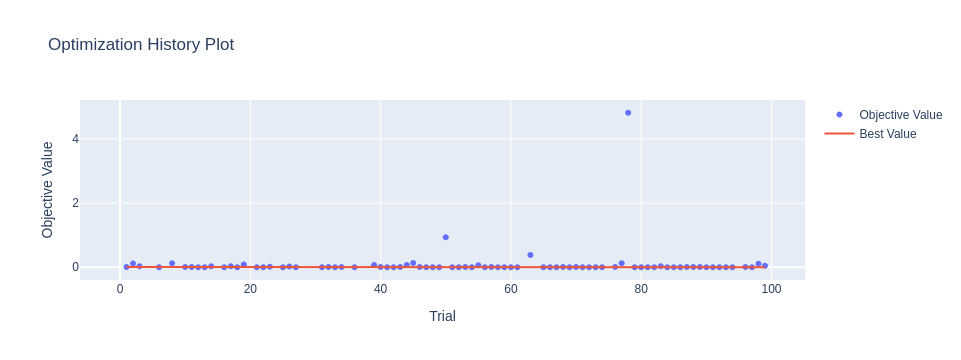

In [61]:
study = optuna_ma(files, 100, 100)
fig = optuna.visualization.plot_optimization_history(study)
print(study.best_trial.params)
show(fig)

In [35]:
study.best_trial.params["seed"]

974.1352018652519

0
Data done
(15000, 249) (15000, 249) (15000, 249) (15000,)
(100, 249) (100, 249) (100, 249) (100,)
Done.
1
Data done
(15000, 249) (15000, 249) (15000, 249) (15000,)
(100, 249) (100, 249) (100, 249) (100,)
Done.
2
Data done
(15000, 249) (15000, 249) (15000, 249) (15000,)
(100, 249) (100, 249) (100, 249) (100,)
Done.
3
Data done
(15000, 249) (15000, 249) (15000, 249) (15000,)
(100, 249) (100, 249) (100, 249) (100,)
Done.
4
Data done
(15000, 249) (15000, 249) (15000, 249) (15000,)
(100, 249) (100, 249) (100, 249) (100,)
Done.
5
Data done
(15000, 249) (15000, 249) (15000, 249) (15000,)
(100, 249) (100, 249) (100, 249) (100,)
Done.
6
Data done
(15000, 249) (15000, 249) (15000, 249) (15000,)
(100, 249) (100, 249) (100, 249) (100,)
Done.
7
Data done
(15000, 249) (15000, 249) (15000, 249) (15000,)
(100, 249) (100, 249) (100, 249) (100,)
Done.
8
Data done
(15000, 249) (15000, 249) (15000, 249) (15000,)
(100, 249) (100, 249) (100, 249) (100,)
Done.
9
Data done
(15000, 249) (15000, 249) (15000, 

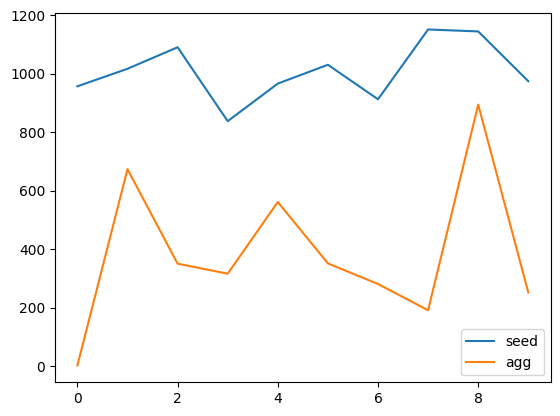

In [49]:
best_seed = []
best_agg = []
for i in range(10):
    print(i)
    study = optuna_ma(files, 100, 100)
    best_seed.append(study.best_trial.params["seed"])
    best_agg.append(study.best_trial.params["agg"])

plt.plot(best_seed, label="seed")
plt.plot(best_agg, label="agg")
plt.legend()
print("seed mu:",np.mean(best_seed), "sigma:", np.std(best_seed))
print("agg mu:",np.mean(best_agg), "sigma:", np.std(best_agg))


seed mu: 1007.8416251827297 sigma: 94.95573906423868
agg mu: 386.9947562629602 sigma: 243.60119432809847


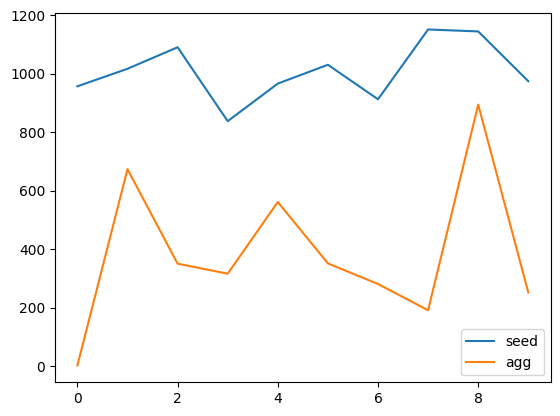

In [59]:
plt.plot(best_seed, label="seed")
plt.plot(best_agg, label="agg")
plt.legend()
print("seed mu:",np.mean(best_seed), "sigma:", np.std(best_seed))
print("agg mu:",np.mean(best_agg), "sigma:", np.std(best_agg))


# Image test

In [10]:
img_data = torch.load("/home/bjartur/workspace/nn_clustering/" + "E150_P3_N1000_IMG.pt")

In [15]:
def plot_tensor(tensor, idx, fig=None, ax=None):
    if ax==None:
        fig,ax = plt.subplots()
    im = ax.imshow(tensor[idx][0])
    cbar = fig.colorbar(im, ax=ax)

def ma_image(tensor, idx):
    adj = np.load("p2_image_adj_21x21.npy")
    dims = tensor[idx][0].shape
    values = tensor[idx][0].flatten().numpy()

    labels = ModifiedAggregation(adj, values, seed=0.7, agg=0.1)
    colors = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

    for l in set(labels):
        if l == 0:
            continue
        mask = labels == l
        plt.imshow(mask.reshape(dims[0],dims[1]), cmap=colors[l])
        plt.show()
    
#    print(labels)

#plot_tensor(img_data["event"], 15)
#plot_tensor(img_data["target"], 10)
#ma_image(img_data["event"], 15)
#ma_image(img_data["target"], 10)

[3.]


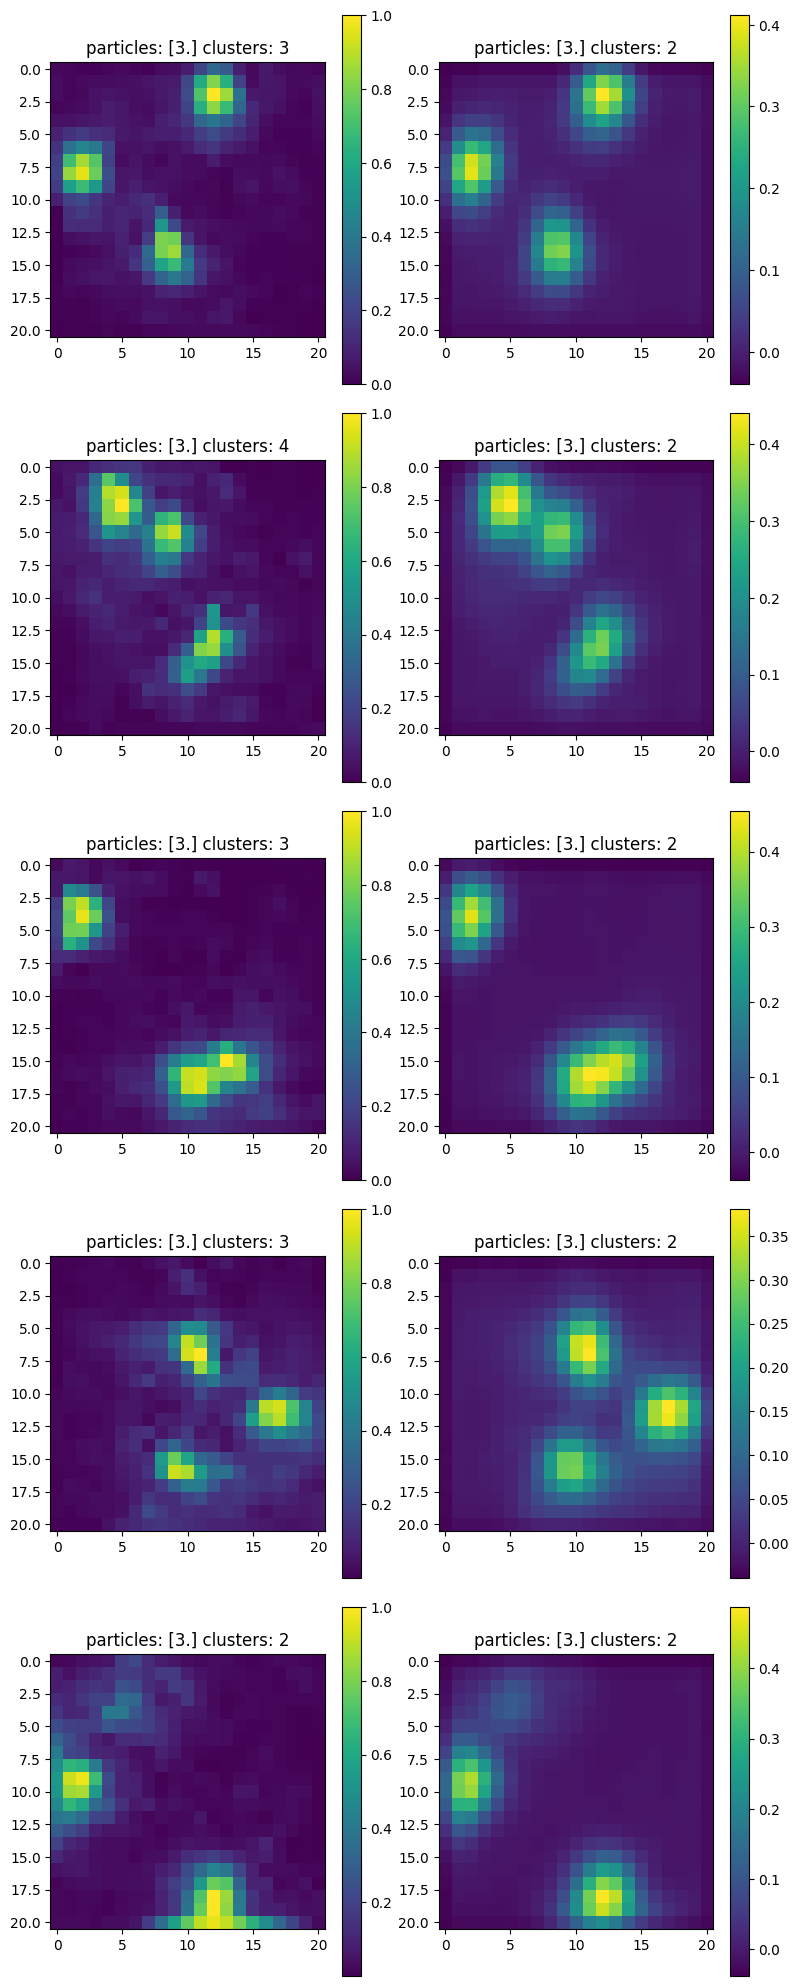

In [18]:
def ma_num(A,v,seed=0.01,agg=0.0):
    labels = ModifiedAggregation(A, v, seed=seed, agg=agg)
    labels_num = 0
    for l in set(labels):
        if l == 0:
            continue
        labels_num += 1
    return labels_num

trial_num = 6
eval_data = torch.load("/home/bjartur/workspace/python_focalh_clustering/" + "eval_"+str(trial_num)+".pt").detach().numpy()
x_data = torch.load("/home/bjartur/workspace/python_focalh_clustering/" + "x_"+str(trial_num)+".pt").detach().numpy()
count_data = torch.load("/home/bjartur/workspace/python_focalh_clustering/" + "count_"+str(trial_num)+".pt").detach().numpy()
idx = 0
print(count_data[idx])
rows=5
fig,ax = plt.subplots(nrows=5, ncols=2, figsize=(8,20))
for i in range(rows):
    adj = np.load("p2_image_adj_21x21.npy")

    plot_tensor(eval_data,i,fig,ax[i][0])
    plot_tensor(x_data,i,fig,ax[i][1])
    eval_max = eval_data[i][0].max()
    x_max = x_data[i].max()
    ax[i][0].set_title("particles: "+str(count_data[i])+" clusters: "+str(ma_num(adj,eval_data[i][0].flatten(),seed=eval_max*0.5,agg=0.0)))
    ax[i][1].set_title("particles: "+str(count_data[i])+" clusters: "+str(ma_num(adj,x_data[i].flatten(),seed=0.3437497859708318,agg=0.003847993060723698)))
fig.tight_layout()